<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# load dataset
stock_price_df = read_csv('./data/VN30_price.csv', header=0, index_col=0)
values = stock_price_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
stock_price_df.head()

,BID,BVH,CTG,FPT,GAS,HPG,KDH,MBB,MSN,MWG,...,PNJ,REE,SBT,SSI,STB,TCH,VCB,VIC,VNM,VN30
2016-12-30,10531.3,58200.0,15050.0,15852.0,60600.0,6770.2,9221.5,5151.6,43200.0,18328.0,...,22097.6,24650.0,20035.1,9521.4,9450.0,12181.1,26307.0,34711.0,99213.0,628.21
2017-01-03,11235.8,59300.0,16100.0,16158.2,60100.0,6903.6,9198.4,5059.6,43600.0,18411.0,...,22164.0,25000.0,21261.8,9740.0,8790.0,12181.1,27643.0,34380.0,100082.0,633.89
2017-01-04,11458.3,60100.0,16400.0,16302.3,61500.0,6903.6,9198.4,5004.4,42333.0,18481.0,...,22230.5,25000.0,20771.1,9740.0,8200.0,12109.0,27457.0,34752.0,100240.0,632.70
2017-01-05,11421.2,61100.0,16500.0,16248.3,61500.0,6919.3,8944.8,4967.6,42067.0,18540.0,...,22263.7,25300.0,20607.6,9764.3,8580.0,12289.2,27569.0,34959.0,100082.0,634.83
2017-01-06,11680.8,61400.0,16650.0,16194.3,60400.0,6809.4,9083.2,5059.6,42133.0,18540.0,...,22895.1,25000.0,20525.8,9861.4,8780.0,12217.1,28125.0,35620.0,99529.0,636.34


In [2]:
column_names = stock_price_df.columns

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('{}(t-{})'.format(column_names[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('{}(t)'.format(column_names[j])) for j in range(n_vars)]
		else:
			names += [('{}(t+{})'.format(column_names[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
Shift_df = stock_price_df.copy()

In [5]:
for col in column_names:
    stock_price_df["Diff" + column_names] = stock_price_df[column_names].diff()

In [6]:
n_days_lag = 10
n_features = len(column_names)

reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)


In [7]:
reframed.head()

,BID(t-10),BVH(t-10),CTG(t-10),FPT(t-10),GAS(t-10),HPG(t-10),KDH(t-10),MBB(t-10),MSN(t-10),MWG(t-10),...,PNJ(t),REE(t),SBT(t),SSI(t),STB(t),TCH(t),VCB(t),VIC(t),VNM(t),VN30(t)
2017-01-17,704.5,1100.0,1050.0,306.2,-500.0,133.4,-23.1,-92.0,400.0,83.0,...,-66.5,0.0,0.0,97.2,280.0,-360.3,1187.0,-165.0,-316.0,4.84
2017-01-18,222.5,800.0,300.0,144.1,1400.0,0.0,0.0,-55.2,-1267.0,70.0,...,99.7,750.0,0.0,-97.2,210.0,-144.2,-482.0,-455.0,-79.0,-4.44
2017-01-19,-37.1,1000.0,100.0,-54.0,0.0,15.7,-253.6,-36.8,-266.0,59.0,...,0.0,0.0,-245.3,-121.4,140.0,-108.1,-223.0,-82.0,0.0,-2.10
2017-01-20,259.6,300.0,150.0,-54.0,-1100.0,-109.9,138.4,92.0,66.0,0.0,...,0.0,-150.0,245.3,0.0,-90.0,756.8,0.0,0.0,790.0,3.28
2017-01-23,333.7,200.0,450.0,90.0,100.0,-39.2,0.0,-18.4,-400.0,-129.0,...,0.0,-750.0,-81.7,-72.9,50.0,0.0,75.0,0.0,790.0,1.14


In [8]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
#y is the VN30 price
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1191, 220) (1191, 22) (298, 220) (298, 22)


In [9]:
test_df = stock_price_df[n_train_days:]
train_df = stock_price_df[:n_train_days]

In [10]:
RFRoost_model = RandomForestRegressor()
RFRoost_model.fit(train_X, train_y)


RandomForestRegressor()

In [11]:
train_idx = stock_price_df.index <= reframed[:n_train_days].index[-1]
test_idx = ~train_idx

train_idx[:n_days_lag+1] = False

In [12]:
RFRoost_model.score(train_X, train_y)

0.855442551679198

In [13]:
RFRoost_model.score(test_X, test_y)

-0.11693782696510917

In [14]:
RFRoost_model.predict(train_X)[:, 1].shape

(1191,)

In [15]:
for i, col in enumerate(column_names):
    stock_price_df[f'Shift{col}'] = stock_price_df[col].shift(1)
    prev = stock_price_df[f'Shift{col}']
    stock_price_df.loc[train_idx, f'{col}-RFR_1_step_train'] = prev[train_idx] + RFRoost_model.predict(train_X)[:, i]
    stock_price_df.loc[test_idx, f'{col}-RFR_1_step_test'] = prev[test_idx] + RFRoost_model.predict(test_X)[:, i]

In [16]:
observe_date = reframed[n_train_days-10:].index[0]

<Axes: >

<Figure size 1000x600 with 0 Axes>

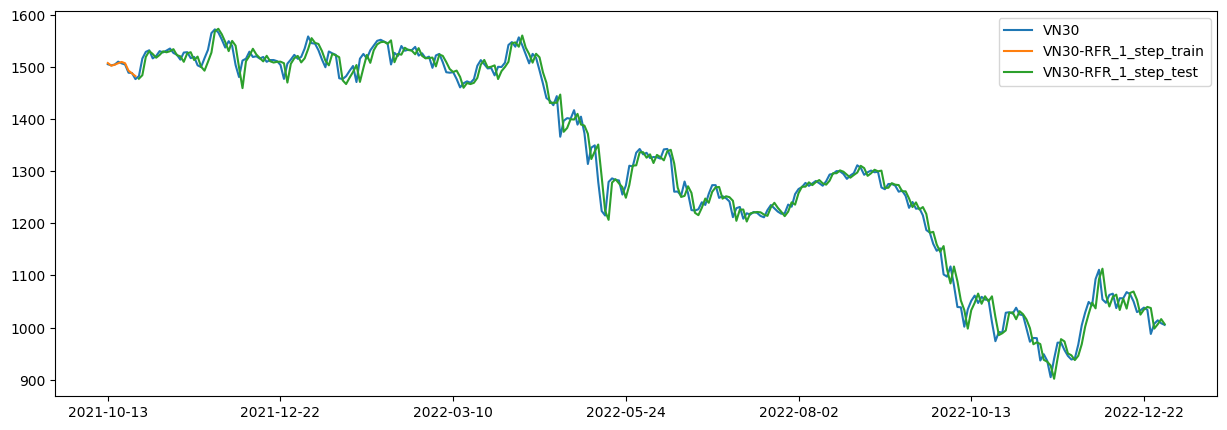

In [17]:
plt.figure(figsize=(10, 6))
stock_price_df[stock_price_df.index > observe_date][['VN30', 'VN30-RFR_1_step_train', 'VN30-RFR_1_step_test']].plot(figsize=(15,5))

In [18]:
test_X[[0], :].shape

(1, 220)

In [19]:
test_X

array([[  197.8 ,   -99.  ,  -195.2 , ...,   300.  ,  -380.4 ,   -11.74],
       [ -277.  , -1873.  ,   -97.6 , ...,   100.  ,  -475.4 ,     5.65],
       [ -277.  ,   -99.  ,   -97.7 , ...,  2800.  ,   760.7 ,    33.84],
       ...,
       [  100.  ,  -150.  ,  -250.  , ...,   500.  ,   600.  ,    19.59],
       [  200.  ,  -250.  ,   350.  , ...,   100.  ,   400.  ,     6.59],
       [ -100.  ,   100.  ,  -200.  , ...,   100.  ,     0.  ,    -5.65]])

In [20]:
n_observe_days = 5
multistep_forecasting = []
last_x = test_X[[0]]
while len(multistep_forecasting) < n_observe_days:
    p = RFRoost_model.predict(last_x)
    multistep_forecasting.append(p)
    last_x = np.roll(last_x, -n_features)
    for i in range(n_features):
        last_x[0, -(n_features-i)] = p[0, i]


In [21]:
import copy
multistep_idx = copy.deepcopy(test_idx)
multistep_idx[n_train_days+n_days_lag+1+n_observe_days:] = False
multistep_idx.sum()

5

In [22]:
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-RFR_multistep'] = last_train + np.cumsum([p[0,i] for  p in multistep_forecasting])

<Axes: >

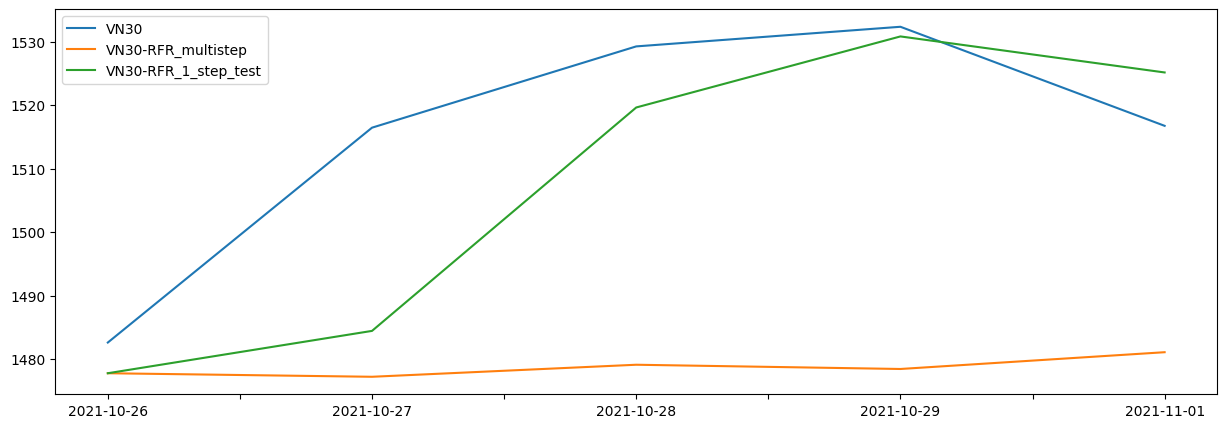

In [23]:
stock_price_df[multistep_idx][['VN30', 'VN30-RFR_multistep', 'VN30-RFR_1_step_test']].plot(figsize=(15,5))

In [56]:
from joblib import dump, load

dump(RFRoost_model, 'RFRoost_model.joblib')

RFRoost_model = load('RFRoost_model.joblib')


Shift_df = stock_price_df.copy()
for col in column_names:
    stock_price_df[f"Diff{col}"] = stock_price_df[col].diff()

n_days_lag = 10
n_features = len(column_names)
reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)
n_obs = n_days_lag * n_features

last_input_sequence = reframed.values[-1:, :n_obs]



In [57]:
last_input_sequence.shape

(1, 220)

In [58]:
a = []
b = np.random.rand(1, 22)
a.append(b)

In [62]:
prediction = RFRoost_model.predict(last_input_sequence)
prediction.shape

(1, 22)

In [65]:
last_values = stock_price_df[column_names].iloc[-1]
last_values.shape

(22,)

PREDICT HERE

In [75]:
from joblib import dump, load

dump(RFRoost_model, 'save/RFRoost_model.joblib')

RFRoost_model = load('save/RFRoost_model.joblib')


Shift_df = stock_price_df.copy()
for col in column_names:
    stock_price_df[f"Diff{col}"] = stock_price_df[col].diff()

n_days_lag = 10
n_features = len(column_names)
reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)
n_obs = n_days_lag * n_features

last_input_sequence = reframed.values[-1:, :n_obs]


predictions = []
last_values = stock_price_df[column_names].iloc[-1].values.reshape(1, n_features)
n_predict = 5
for i in range(n_predict):
    prediction = RFRoost_model.predict(last_input_sequence)

    prediction = prediction.reshape((1, n_features))


    last_input_sequence = np.roll(last_input_sequence, -n_features)
    last_input_sequence[:, -n_features:] = prediction
    # print(type(prediction))
    last_values = last_values + prediction
    predictions.append(last_values)
predictions = np.array(predictions).reshape(n_predict, n_features)
predictions.shape
predicted_values_df = pd.DataFrame(data=predictions, columns=column_names)
predicted_values_df

,BID,BVH,CTG,FPT,GAS,HPG,KDH,MBB,MSN,MWG,...,PNJ,REE,SBT,SSI,STB,TCH,VCB,VIC,VNM,VN30
0,38522.120,46454.95,27176.966,76792.587,101394.57,17965.988,26511.893,17076.591,93139.52,42923.63,...,89731.250,71523.880,14463.498,17627.329,22435.0,6728.300,79878.50,53719.58,75603.578,1003.5382
1,38468.473,46339.16,27176.694,76948.992,101518.05,18078.204,26591.886,17130.821,93353.64,42920.10,...,89672.629,71786.520,14420.859,17705.797,22511.2,6692.932,79886.33,53654.32,75402.644,1005.4906
2,38377.287,46258.31,27237.301,76886.769,101463.89,18068.785,26635.801,17125.529,93472.86,42851.29,...,89660.683,71739.039,14534.563,17724.913,22549.1,6687.119,79945.48,53554.34,76737.197,1005.8321
3,38208.844,46174.70,27076.805,76781.487,101319.44,17961.126,26501.493,17040.523,93117.71,42536.29,...,89490.448,71770.419,14470.432,17704.779,22383.1,6679.458,79797.64,53206.96,76738.081,1001.2439
4,38151.858,46073.57,27119.171,76961.659,101057.29,18009.698,26619.826,17092.889,93395.06,42701.02,...,89539.263,71850.319,14552.568,17820.826,22459.7,6683.345,79973.16,53448.16,76710.881,1003.8026


In [24]:
multiouput_df = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, n_observe_days)
n_obs = n_days_lag * n_features

values = multiouput_df.values
n_train_days = int(len(multiouput_df.index) * 0.9)
train_m = values[:n_train_days, :]
test_m = values[n_train_days:n_train_days+n_observe_days, :]
train_X_m, train_y_m = train_m[:, :n_obs], train_m[:, n_obs:]
test_X_m, test_y_m = test_m[:, :n_obs], test_m[:, n_obs:]
multioutput_RFRoost_model = RandomForestRegressor()
multioutput_RFRoost_model.fit(train_X_m, train_y_m)
multioutput_RFRoost_model.score(train_X_m, train_y_m)

KeyboardInterrupt: 

In [ ]:
multiouput_df

,BID(t-10),BVH(t-10),CTG(t-10),FPT(t-10),GAS(t-10),HPG(t-10),KDH(t-10),MBB(t-10),MSN(t-10),MWG(t-10),...,PNJ(t+4),REE(t+4),SBT(t+4),SSI(t+4),STB(t+4),TCH(t+4),VCB(t+4),VIC(t+4),VNM(t+4),VN30(t+4)
2017-01-17,704.5,1100.0,1050.0,306.2,-500.0,133.4,-23.1,-92.0,400.0,83.0,...,0.0,-750.0,-81.7,-72.9,50.0,0.0,75.0,0.0,790.0,1.14
2017-01-18,222.5,800.0,300.0,144.1,1400.0,0.0,0.0,-55.2,-1267.0,70.0,...,-99.7,500.0,0.0,24.3,300.0,-108.1,371.0,-413.0,0.0,3.90
2017-01-19,-37.1,1000.0,100.0,-54.0,0.0,15.7,-253.6,-36.8,-266.0,59.0,...,132.9,350.0,-81.8,72.9,350.0,216.2,519.0,413.0,790.0,5.47
2017-01-20,259.6,300.0,150.0,-54.0,-1100.0,-109.9,138.4,92.0,66.0,0.0,...,498.5,300.0,-245.3,218.6,-150.0,-108.1,111.0,413.0,3159.0,8.19
2017-01-23,333.7,200.0,450.0,90.0,100.0,-39.2,0.0,-18.4,-400.0,-129.0,...,-133.0,-100.0,0.0,-72.9,0.0,-72.1,-556.0,-413.0,711.0,-1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,-2150.0,-2500.0,-1600.0,-2300.0,-3700.0,-1400.0,-1550.0,-1300.0,-3000.0,-3250.0,...,-450.0,-3600.0,-1000.0,-1250.0,-1600.0,-480.0,-200.0,-2200.0,-200.0,-46.36
2022-12-21,-100.0,300.0,350.0,500.0,-2700.0,-350.0,350.0,-400.0,-2000.0,500.0,...,0.0,1700.0,100.0,1150.0,600.0,420.0,200.0,500.0,600.0,19.59
2022-12-22,0.0,200.0,450.0,500.0,-800.0,650.0,400.0,800.0,-4000.0,1150.0,...,1500.0,-200.0,450.0,-50.0,400.0,0.0,900.0,100.0,400.0,6.59
2022-12-23,200.0,-600.0,250.0,1000.0,0.0,300.0,-250.0,100.0,1000.0,200.0,...,3500.0,0.0,200.0,-550.0,-550.0,-40.0,700.0,100.0,0.0,-5.65


In [ ]:
multioutput_RFRoost_model.score(test_X_m, test_y_m)

-1.4414413114854574

In [ ]:
test_X_m[[0]].shape

(1, 220)

In [ ]:
multioutput_RFRoost_model.predict(test_X_m[[0]])[0,5]

-476.278

In [ ]:
multiouput_predict = multioutput_RFRoost_model.predict(test_X_m[[0]])
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-RFR_multioutput'] = last_train + np.cumsum([multiouput_predict[0, t*n_features+i] for t in range(n_observe_days)])

<Axes: >

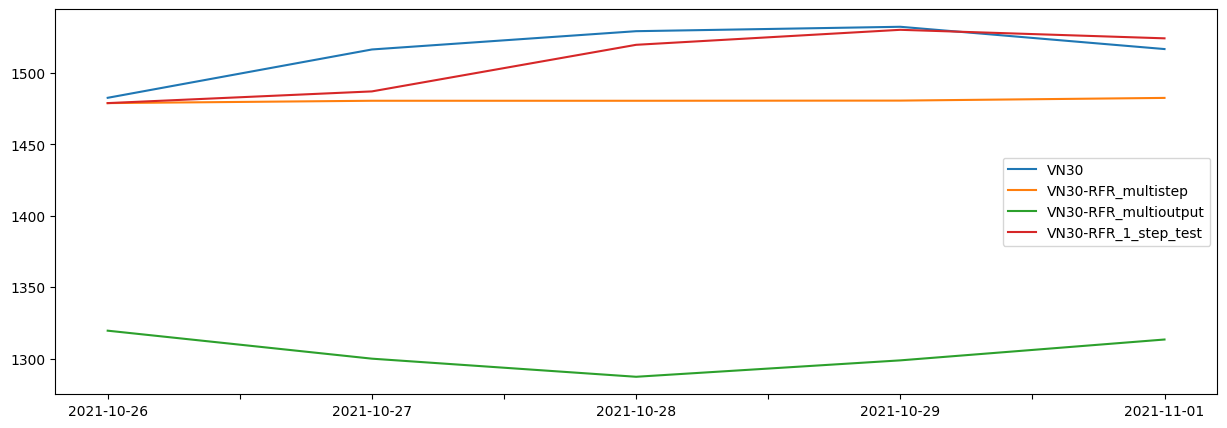

In [ ]:
stock_price_df[multistep_idx][['VN30', 'VN30-RFR_multistep', 'VN30-RFR_multioutput', 'VN30-RFR_1_step_test']].plot(figsize=(15,5))

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [ ]:
test = stock_price_df.copy()[['VN30-RFR_multistep', 'VN30-RFR_multioutput', 'VN30']]
test.dropna(inplace=True)
print('\nForecast Accuracy of Incremental multistep (base on one step ahead): VN30')
accuracy_prod = forecast_accuracy(test['VN30-RFR_multistep'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
print('\nForecast Accuracy of Multi output model n_step ahead: VN30')
accuracy_prod = forecast_accuracy(test['VN30-RFR_multioutput'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of Incremental multistep (base on one step ahead): VN30
mape   :  0.0229
me     :  -34.8453
mae    :  34.8453
mpe    :  -0.0229
rmse   :  38.7753
corr   :  0.5736
minmax :  0.0229

Forecast Accuracy of Multi output model n_step ahead: VN30
mape   :  0.1395
me     :  -211.6824
mae    :  211.6824
mpe    :  -0.1395
rmse   :  213.4949
corr   :  -0.8152
minmax :  0.1395


In [ ]:
accuracy_prod = forecast_accuracy(test['VN30-RFR_multioutput'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  0.1395
me     :  -211.6824
mae    :  211.6824
mpe    :  -0.1395
rmse   :  213.4949
corr   :  -0.8152
minmax :  0.1395


In [ ]:
print('\nForecast Accuracy of One-step ahead: VN30')
test = stock_price_df.copy()[['VN30-RFR_1_step_test', 'VN30']]
test.dropna(inplace=True)
accuracy_prod = forecast_accuracy(test['VN30-RFR_1_step_test'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of One-step ahead: VN30
mape   :  0.0117
me     :  0.3698
mae    :  14.6459
mpe    :  0.0005
rmse   :  20.206
corr   :  0.9946
minmax :  0.0115


<Axes: >

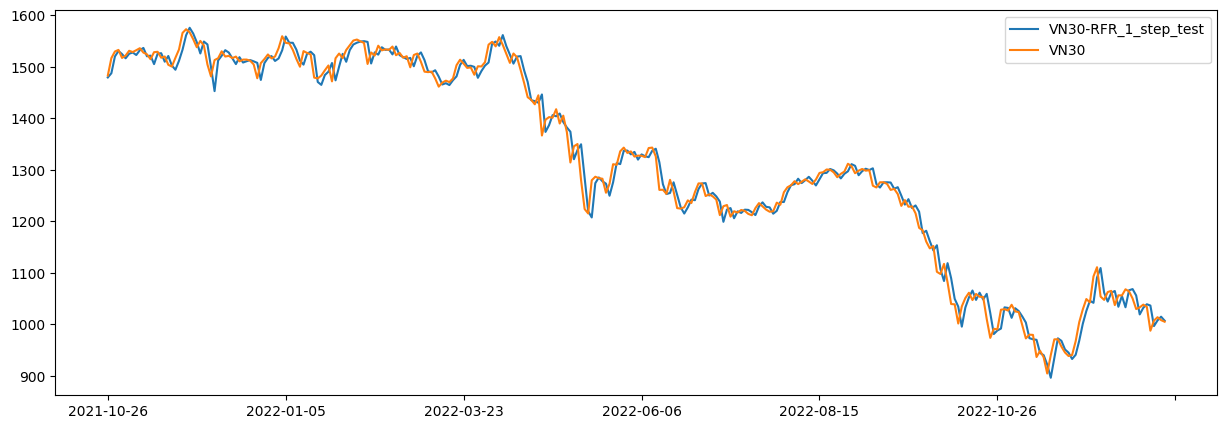

In [ ]:
test.plot(figsize=(15,5))